In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import json



from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from spdnetwork.optimizers import  MixOptimizer 
from spdnetwork.nn import LogEig
from Utils import get_fold_of_data
from DatasetManagement import DatasetManagement
from Models import   Contrastive_CB3, SPDnet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


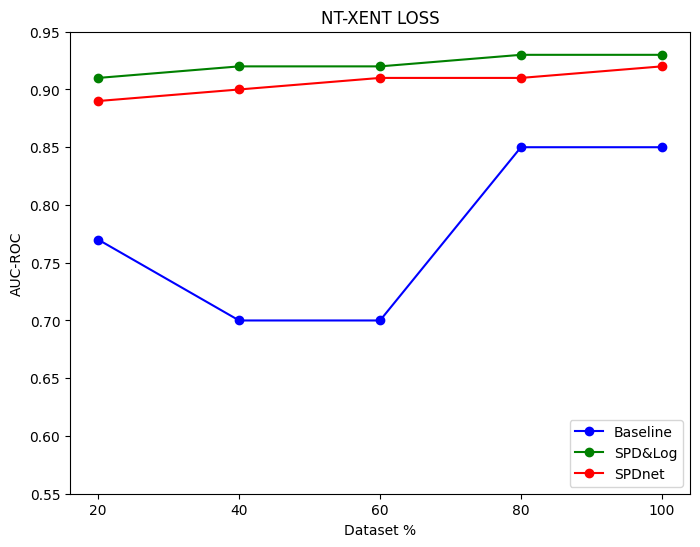

In [2]:
import matplotlib.pyplot as plt

# Dataset percentage and AUC values
dataset_percentage = [20, 40, 60, 80, 100]

auc_baseline = [0.77, 0.70, 0.70, 0.85, 0.85] # LR
auc_spd = [0.91, 0.92, 0.92, 0.93, 0.93] # SVM
auc_spdnet = [0.89, 0.90, 0.91, 0.91, 0.92]


# Plotting the graph with updated legend position and title
plt.figure(figsize=(8, 6))
plt.plot(dataset_percentage, auc_baseline, marker='o', color='blue', label='Baseline')
plt.plot(dataset_percentage, auc_spd, marker='o', color='green', label='SPD&Log')
plt.plot(dataset_percentage, auc_spdnet, marker='o', color='red', label='SPDnet')


# Setting labels and title
plt.xlabel('Dataset %')
plt.ylabel('AUC-ROC')
plt.ylim([0.55, 0.95])  # Matching the scale of the example image
plt.xticks(dataset_percentage)  # Show only specific x-axis labels
plt.legend(loc='lower right')  # Position the legend at the bottom right
plt.title("NT-XENT LOSS")  # Add title at the top

# Display the graph
plt.grid(False)
plt.show()




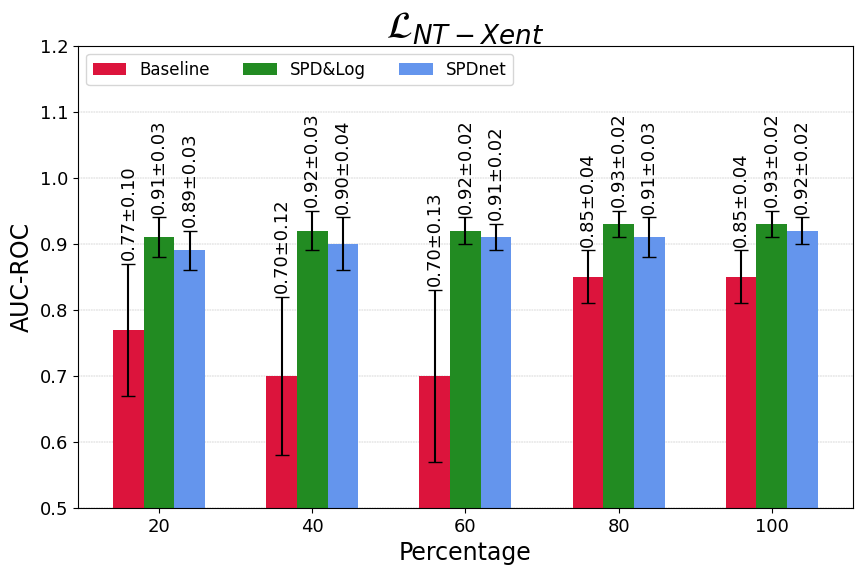

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset percentage and AUC values
dataset_percentage = [20, 40, 60, 80, 100]

# AUC values with standard deviations for each model
auc_baseline = [0.77, 0.70, 0.70, 0.85, 0.85]  # LR
auc_baseline_std = [0.10, 0.12, 0.13, 0.04, 0.04]  # Baseline std

auc_spd = [0.91, 0.92, 0.92, 0.93, 0.93]  # SVM
auc_spd_std = [0.03, 0.03, 0.02, 0.02, 0.02]  # SPD std

auc_spdnet = [0.89, 0.90, 0.91, 0.91, 0.92]
auc_spdnet_std = [0.03, 0.04, 0.02, 0.03, 0.02]  # 

# Width of the bars
bar_width = 0.2

# X-axis positions for each model
r1 = np.arange(len(dataset_percentage))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure grid lines are behind the bars
ax.set_axisbelow(True)

# Add horizontal grid lines only (soft)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.35)

# Plot the bars
ax.bar(r1, auc_baseline, width=bar_width, color='crimson', yerr=auc_baseline_std, capsize=5, label='Baseline')
ax.bar(r2, auc_spd, width=bar_width, color='forestgreen', yerr=auc_spd_std, capsize=5, label='SPD&Log')
ax.bar(r3, auc_spdnet, width=bar_width, color='cornflowerblue', yerr=auc_spdnet_std, capsize=5, label='SPDnet')

# Add text annotations for the AUC values on top of the bars with vertical rotation
for i in range(len(r1)):
    ax.text(r1[i], auc_baseline[i] + auc_baseline_std[i] + 0.006, f'{auc_baseline[i]:.2f}±{auc_baseline_std[i]:.2f}', 
             ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r2[i], auc_spd[i] + auc_spd_std[i] + 0.006, f'{auc_spd[i]:.2f}±{auc_spd_std[i]:.2f}', 
             ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r3[i], auc_spdnet[i] + auc_spdnet_std[i] + 0.006, f'{auc_spdnet[i]:.2f}±{auc_spdnet_std[i]:.2f}', 
             ha='center', va='bottom', fontsize=13, rotation=90)

# General layout
ax.set_title('$\mathcal{L}_{NT-Xent}$', fontsize=27)
ax.set_xlabel('Percentage', fontsize=17)
ax.set_ylabel('AUC-ROC', fontsize=17)
ax.set_xticks([r + bar_width for r in range(len(dataset_percentage))])
ax.set_xticklabels(dataset_percentage)

# Cambiar el tamaño de los números del eje x e y
ax.tick_params(axis='x', labelsize=13)  # Tamaño de los números en el eje x
ax.tick_params(axis='y', labelsize=13)  # Tamaño de los números en el eje y

ax.set_ylim([0.5, 1.2])

# Add the legend in the upper left corner
ax.legend(loc='upper left', bbox_to_anchor=(0,1), frameon=True, ncol=3, fontsize=12)

# Show the plot
plt.savefig('/data/ProstateContrastiveSPD/figslibro/auc_plotNTXENT.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


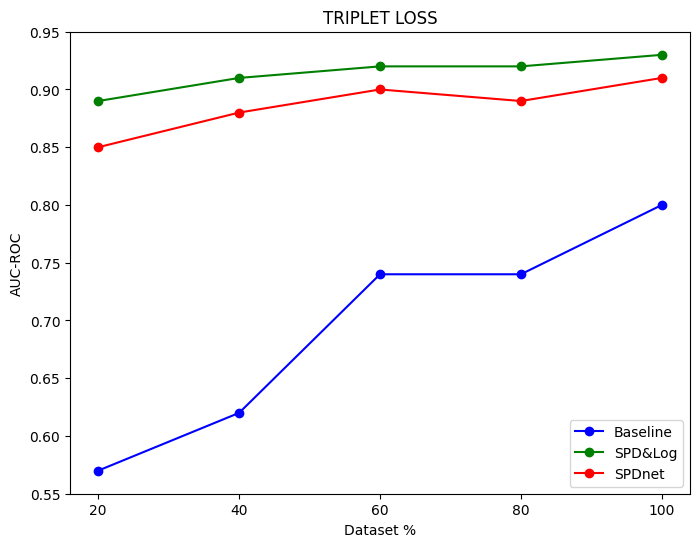

In [2]:
import matplotlib.pyplot as plt

# Dataset percentage and AUC values
dataset_percentage = [20, 40, 60, 80, 100]

auc_baseline = [0.57, 0.62, 0.74, 0.74, 0.80] #LR
auc_spd = [0.89, 0.91, 0.92, 0.92, 0.93]#SVM
auc_spdnet = [0.85, 0.88, 0.90, 0.89 , 0.91]

# Plotting the graph with updated legend position and title
plt.figure(figsize=(8, 6))
plt.plot(dataset_percentage, auc_baseline, marker='o', color='blue', label='Baseline')
plt.plot(dataset_percentage, auc_spd, marker='o', color='green', label='SPD&Log')
plt.plot(dataset_percentage, auc_spdnet, marker='o', color='red', label='SPDnet')


# Setting labels and title
plt.xlabel('Dataset %')
plt.ylabel('AUC-ROC')
plt.ylim([0.55, 0.95])  # Matching the scale of the example image
plt.xticks(dataset_percentage)  # Show only specific x-axis labels
plt.legend(loc='lower right')  # Position the legend at the bottom right
plt.title("TRIPLET LOSS")  # Add title at the top

# Display the graph
plt.grid(False)
plt.show()




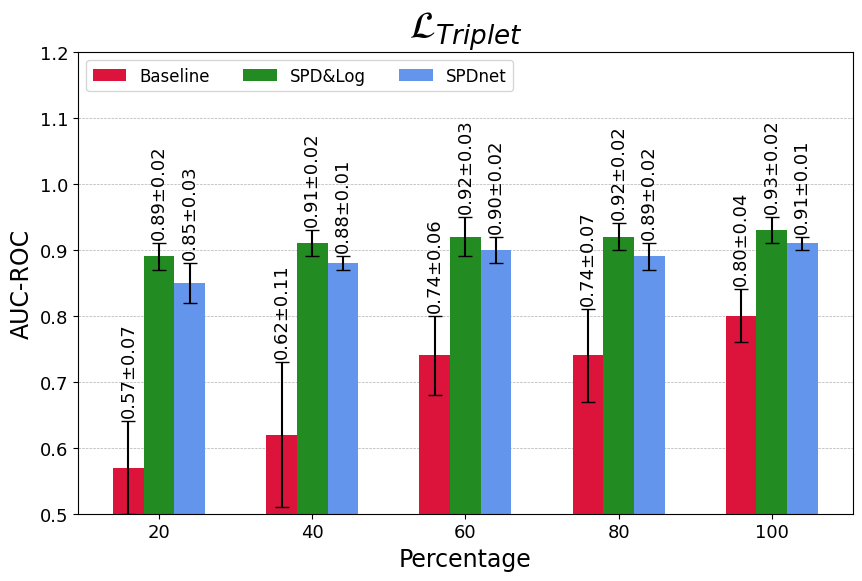

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset percentage and AUC values
dataset_percentage = [20, 40, 60, 80, 100]

# AUC values with standard deviations for each model
auc_baseline = [0.57, 0.62, 0.74, 0.74, 0.80]  # LR
auc_baseline_std = [0.07, 0.11, 0.06, 0.07, 0.04]  # Baseline std

auc_spd = [0.89, 0.91, 0.92, 0.92, 0.93]  # SVM
auc_spd_std = [0.02, 0.02, 0.03, 0.02, 0.02]  # SPD std

auc_spdnet = [0.85, 0.88, 0.90, 0.89, 0.91]
auc_spdnet_std = [0.03, 0.01, 0.02, 0.02, 0.01]  # 

# Width of the bars
bar_width = 0.2

# X-axis positions for each model
r1 = np.arange(len(dataset_percentage))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure grid lines are behind the bars
ax.set_axisbelow(True)

# Add horizontal grid lines only (soft)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Plot the bars
ax.bar(r1, auc_baseline, width=bar_width, color='crimson', yerr=auc_baseline_std, capsize=5, label='Baseline')
ax.bar(r2, auc_spd, width=bar_width, color='forestgreen', yerr=auc_spd_std, capsize=5, label='SPD&Log')
ax.bar(r3, auc_spdnet, width=bar_width, color='cornflowerblue', yerr=auc_spdnet_std, capsize=5, label='SPDnet')

# Add text annotations for the AUC values on top of the bars with vertical rotation
for i in range(len(r1)):
    ax.text(r1[i], auc_baseline[i] + auc_baseline_std[i] + 0.006, f'{auc_baseline[i]:.2f}±{auc_baseline_std[i]:.2f}', 
            ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r2[i], auc_spd[i] + auc_spd_std[i] + 0.006, f'{auc_spd[i]:.2f}±{auc_spd_std[i]:.2f}', 
            ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r3[i], auc_spdnet[i] + auc_spdnet_std[i] + 0.006, f'{auc_spdnet[i]:.2f}±{auc_spdnet_std[i]:.2f}', 
            ha='center', va='bottom', fontsize=13, rotation=90)

# General layout
ax.set_title('$\mathcal{L}_{Triplet}$', fontsize=27)
ax.set_xlabel('Percentage', fontsize=17)
ax.set_ylabel('AUC-ROC', fontsize=17)
ax.set_xticks([r + bar_width for r in range(len(dataset_percentage))])
ax.set_xticklabels(dataset_percentage)
# Cambiar el tamaño de los números del eje x e y
ax.tick_params(axis='x', labelsize=13)  # Tamaño de los números en el eje x
ax.tick_params(axis='y', labelsize=13)  # Tamaño de los números en el eje y

ax.set_ylim([0.5, 1.2])

# Add the legend in the upper left corner
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, ncol=3, fontsize=12)

plt.savefig('/data/ProstateContrastiveSPD/figslibro/auc_plotTRIPLET.pdf', format='pdf', bbox_inches='tight', dpi=300)


# Show the plot
plt.show()


In [ ]:
#Organizo las etiquetas de los datos de validación
labels = []
destination_path = '/data/ProstateContrastiveSPD/labels/labelsISUP/'
fold_indexes = open('/data/picai_folds_indexes.json', 'r')
indexdes = json.load(fold_indexes)

info = open('/data/info-12x32x32.json', 'r')
info_json = json.load(info)


for i in range(5):
    for patient_id in indexdes[f'Fold_{i}_val']:
        labels.append(info_json[patient_id]['case_ISUP'])
        
labels_np = np.array(labels)

os.makedirs(destination_path, exist_ok=True)
destine_path = os.path.join(destination_path, "labels_val.npy")
# Guardar el archivo np.array en la ruta especificada
np.save(destine_path, labels_np)


        


# Calcular predicciones

$SPDnet$ con las dos pérdidas 100%

In [3]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc
import numpy as np

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list_auc = []
list_accuracy = []
list_aucpr = []

destination_path = "/data/Predictions/SPDnetNTXENT/predictions_val.npy" #cambiar////////////////////////////
all_predictions = []  # Lista para acumular las probabilidades de los datos de validación

# Definir una función para cargar los datos y etiquetas de validación
def load_data(embeddings_path, labels_path):
    embeddings = torch.load(embeddings_path, map_location=device)
    labels = torch.load(labels_path, map_location=device)
    return embeddings, labels

# Definir una función para evaluar el modelo y calcular métricas
def evaluate_model(model, val_embeddings, val_labels):
    model.eval()
    with torch.no_grad():
        # Obtener las predicciones del modelo
        outputs = model(val_embeddings)
        # Aplicar softmax para obtener probabilidades
        probs = F.softmax(outputs, dim=1)[:, 1]  # Obtener las probabilidades para la clase 1
        preds = torch.argmax(outputs, dim=1)
        
        # Calcular AUC-ROC
        auc_roc = roc_auc_score(val_labels.cpu().numpy(), probs.cpu().numpy())
        
        # Calcular Accuracy
        accuracy = accuracy_score(val_labels.cpu().numpy(), preds.cpu().numpy())
        
        # Calcular AUCPR
        precisions, recalls, _ = precision_recall_curve(val_labels.cpu().numpy(), probs.cpu().numpy())
        auc_pr = auc(recalls, precisions)
        
        return auc_roc, accuracy, auc_pr, probs.cpu().numpy()

# Path base para los datos
base_path = "/data/ProstateContrastiveSPD/ResultsSPDembeddings/" #cambiar////////////////////////////        

folds = [1, 2, 3, 4, 5]  # Puedes agregar más folds aquí

for fold in folds:
    # Cargar el modelo para el fold actual
    model_path = f"{base_path}/ResultsSPD2N/fold_{fold}/best_model.pth"
    model = SPDnet(device).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Cargar los datos de validación
    val_embeddings_path = f"/data/Embeddings100%/embeddingsSPD/fold_{fold}/val/embeddingsSPD_val.pt"#cambiar////////////////////////////
    val_labels_path = f"/data/Embeddings100%/embeddingsSPD/fold_{fold}/val/labelsSPD_val.pt"#cambiar////////////////////////////
    
    val_embeddings, val_labels = load_data(val_embeddings_path, val_labels_path)
    val_embeddings = val_embeddings.unsqueeze(1)
    
    # Evaluar el modelo y calcular métricas
    auc_roc, accuracy, auc_pr, probs = evaluate_model(model, val_embeddings, val_labels)
    list_auc.append(auc_roc)
    list_accuracy.append(accuracy)
    list_aucpr.append(auc_pr)
    
    # Acumular las probabilidades de la clase 1 de este fold
    all_predictions.append(probs)
    
    print(f"Fold {fold} - AUC-ROC: {auc_roc:.4f}, Accuracy: {accuracy:.4f}")

# Convertir la lista de predicciones de clase 1 a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)

# Guardar el array de probabilidades de la clase 1 en la ruta especificada
np.save(destination_path, all_predictions_np)

# Imprimir resultados finales
print(f"Promedio de AUC: {np.mean(list_auc)}")
print(f"Desviación estándar: {np.std(list_auc)}")

print(f"Promedio de Accuracy: {np.mean(list_accuracy)}")
print(f"Desviación estándar: {np.std(list_accuracy)}")

print(f"Promedio de AUC-PR: {np.mean(list_aucpr)}")
print(f"Desviación estándar: {np.std(list_aucpr)}")


Fold 1 - AUC-ROC: 0.8869, Accuracy: 0.8423
Fold 2 - AUC-ROC: 0.9028, Accuracy: 0.8144
Fold 3 - AUC-ROC: 0.9137, Accuracy: 0.8819
Fold 4 - AUC-ROC: 0.9694, Accuracy: 0.9245
Fold 5 - AUC-ROC: 0.9286, Accuracy: 0.9167
Promedio de AUC: 0.920254136539201
Desviación estándar: 0.02807051159530419
Promedio de Accuracy: 0.8759572728069237
Desviación estándar: 0.042364920281142214
Promedio de AUC-PR: 0.7889200535751877
Desviación estándar: 0.05608339673420751


$SPDnet$ con las dos pérdidas 20%

In [6]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc
import numpy as np

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list_auc = []
list_accuracy = []
list_aucpr = []

destination_path = "/data/Predictions/SPDnetTriplet20%/predictions_val.npy" #cambiar////////////////////////////
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

all_predictions = []  # Lista para acumular las probabilidades de los datos de validación

# Definir una función para cargar los datos y etiquetas de validación
def load_data(embeddings_path, labels_path):
    embeddings = torch.load(embeddings_path, map_location=device)
    labels = torch.load(labels_path, map_location=device)
    return embeddings, labels

# Definir una función para evaluar el modelo y calcular métricas
def evaluate_model(model, val_embeddings, val_labels):
    model.eval()
    with torch.no_grad():
        # Obtener las predicciones del modelo
        outputs = model(val_embeddings)
        # Aplicar softmax para obtener probabilidades
        probs = F.softmax(outputs, dim=1)[:, 1]  # Obtener las probabilidades para la clase 1
        preds = torch.argmax(outputs, dim=1)
        
        # Calcular AUC-ROC
        auc_roc = roc_auc_score(val_labels.cpu().numpy(), probs.cpu().numpy())
        
        # Calcular Accuracy
        accuracy = accuracy_score(val_labels.cpu().numpy(), preds.cpu().numpy())
        
        # Calcular AUCPR
        precisions, recalls, _ = precision_recall_curve(val_labels.cpu().numpy(), probs.cpu().numpy())
        auc_pr = auc(recalls, precisions)
        
        return auc_roc, accuracy, auc_pr, probs.cpu().numpy()

# Path base para los datos
base_path = "/data/Embeddings20%/" #cambiar////////////////////////////        

folds = [1, 2, 3, 4, 5]  # Puedes agregar más folds aquí

for fold in folds:
    # Cargar el modelo para el fold actual
    model_path = f"{base_path}/results/embeddingsTripletSPD/fold_{fold}/best_model.pth"#CAMBARI
    model = SPDnet(device).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Cargar los datos de validación    
    val_embeddings_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/embeddingsSPD_val.pt"#cambiar////////////////////////////
    val_labels_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/labelsSPD_val.pt"#cambiar////////////////////////////
    
    val_embeddings, val_labels = load_data(val_embeddings_path, val_labels_path)
    val_embeddings = val_embeddings.unsqueeze(1)
    
    # Evaluar el modelo y calcular métricas
    auc_roc, accuracy, auc_pr, probs = evaluate_model(model, val_embeddings, val_labels)
    list_auc.append(auc_roc)
    list_accuracy.append(accuracy)
    list_aucpr.append(auc_pr)
    
    # Acumular las probabilidades de la clase 1 de este fold
    all_predictions.append(probs)
    
    print(f"Fold {fold} - AUC-ROC: {auc_roc:.4f}, Accuracy: {accuracy:.4f}")

# Convertir la lista de predicciones de clase 1 a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)

# Guardar el array de probabilidades de la clase 1 en la ruta especificada
np.save(destination_path, all_predictions_np)

# Imprimir resultados finales
print(f"Promedio de AUC: {np.mean(list_auc)}")
print(f"Desviación estándar: {np.std(list_auc)}")

print(f"Promedio de Accuracy: {np.mean(list_accuracy)}")
print(f"Desviación estándar: {np.std(list_accuracy)}")

print(f"Promedio de AUC-PR: {np.mean(list_aucpr)}")
print(f"Desviación estándar: {np.std(list_aucpr)}")


Fold 1 - AUC-ROC: 0.8214, Accuracy: 0.8385
Fold 2 - AUC-ROC: 0.8607, Accuracy: 0.8409
Fold 3 - AUC-ROC: 0.8325, Accuracy: 0.7835
Fold 4 - AUC-ROC: 0.8437, Accuracy: 0.4000
Fold 5 - AUC-ROC: 0.9053, Accuracy: 0.8135
Promedio de AUC: 0.8527148414803005
Desviación estándar: 0.029341816064547777
Promedio de Accuracy: 0.7352654519583653
Desviación estándar: 0.16891151022543022
Promedio de AUC-PR: 0.665524165906317
Desviación estándar: 0.0511246275456424


$SPDnet$ con las dos pérdidas 40%

In [8]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc
import numpy as np

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list_auc = []
list_accuracy = []
list_aucpr = []

destination_path = "/data/Predictions/SPDnetTriplet40%/predictions_val.npy" #cambiar////////////////////////////
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

all_predictions = []  # Lista para acumular las probabilidades de los datos de validación

# Definir una función para cargar los datos y etiquetas de validación
def load_data(embeddings_path, labels_path):
    embeddings = torch.load(embeddings_path, map_location=device)
    labels = torch.load(labels_path, map_location=device)
    return embeddings, labels

# Definir una función para evaluar el modelo y calcular métricas
def evaluate_model(model, val_embeddings, val_labels):
    model.eval()
    with torch.no_grad():
        # Obtener las predicciones del modelo
        outputs = model(val_embeddings)
        # Aplicar softmax para obtener probabilidades
        probs = F.softmax(outputs, dim=1)[:, 1]  # Obtener las probabilidades para la clase 1
        preds = torch.argmax(outputs, dim=1)
        
        # Calcular AUC-ROC
        auc_roc = roc_auc_score(val_labels.cpu().numpy(), probs.cpu().numpy())
        
        # Calcular Accuracy
        accuracy = accuracy_score(val_labels.cpu().numpy(), preds.cpu().numpy())
        
        # Calcular AUCPR
        precisions, recalls, _ = precision_recall_curve(val_labels.cpu().numpy(), probs.cpu().numpy())
        auc_pr = auc(recalls, precisions)
        
        return auc_roc, accuracy, auc_pr, probs.cpu().numpy()

# Path base para los datos
base_path = "/data/Embeddings40%/" #cambiar////////////////////////////        

folds = [1, 2, 3, 4, 5]  # Puedes agregar más folds aquí

for fold in folds:
    # Cargar el modelo para el fold actual
    model_path = f"{base_path}/results/embeddingsTripletSPD/fold_{fold}/best_model.pth"#CAMBARI
    model = SPDnet(device).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Cargar los datos de validación    
    val_embeddings_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/embeddingsSPD_val.pt"#cambiar////////////////////////////
    val_labels_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/labelsSPD_val.pt"#cambiar////////////////////////////
    
    val_embeddings, val_labels = load_data(val_embeddings_path, val_labels_path)
    val_embeddings = val_embeddings.unsqueeze(1)
    
    # Evaluar el modelo y calcular métricas
    auc_roc, accuracy, auc_pr, probs = evaluate_model(model, val_embeddings, val_labels)
    list_auc.append(auc_roc)
    list_accuracy.append(accuracy)
    list_aucpr.append(auc_pr)
    
    # Acumular las probabilidades de la clase 1 de este fold
    all_predictions.append(probs)
    
    print(f"Fold {fold} - AUC-ROC: {auc_roc:.4f}, Accuracy: {accuracy:.4f}")

# Convertir la lista de predicciones de clase 1 a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)

# Guardar el array de probabilidades de la clase 1 en la ruta especificada
np.save(destination_path, all_predictions_np)

# Imprimir resultados finales
print(f"Promedio de AUC: {np.mean(list_auc)}")
print(f"Desviación estándar: {np.std(list_auc)}")

print(f"Promedio de Accuracy: {np.mean(list_accuracy)}")
print(f"Desviación estándar: {np.std(list_accuracy)}")

print(f"Promedio de AUC-PR: {np.mean(list_aucpr)}")
print(f"Desviación estándar: {np.std(list_aucpr)}")


Fold 1 - AUC-ROC: 0.8597, Accuracy: 0.8923
Fold 2 - AUC-ROC: 0.8717, Accuracy: 0.8977
Fold 3 - AUC-ROC: 0.8727, Accuracy: 0.8976
Fold 4 - AUC-ROC: 0.8839, Accuracy: 0.7623
Fold 5 - AUC-ROC: 0.8936, Accuracy: 0.8373
Promedio de AUC: 0.8763128337749568
Desviación estándar: 0.01156818936193088
Promedio de Accuracy: 0.8574476997111079
Desviación estándar: 0.05276112331805133
Promedio de AUC-PR: 0.7198784524212039
Desviación estándar: 0.02822240364433264


$SPDnet$ con las dos pérdidas 60%

In [10]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc
import numpy as np

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list_auc = []
list_accuracy = []
list_aucpr = []

destination_path = "/data/Predictions/SPDnetTriplet60%/predictions_val.npy" #cambiar////////////////////////////
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

all_predictions = []  # Lista para acumular las probabilidades de los datos de validación

# Definir una función para cargar los datos y etiquetas de validación
def load_data(embeddings_path, labels_path):
    embeddings = torch.load(embeddings_path, map_location=device)
    labels = torch.load(labels_path, map_location=device)
    return embeddings, labels

# Definir una función para evaluar el modelo y calcular métricas
def evaluate_model(model, val_embeddings, val_labels):
    model.eval()
    with torch.no_grad():
        # Obtener las predicciones del modelo
        outputs = model(val_embeddings)
        # Aplicar softmax para obtener probabilidades
        probs = F.softmax(outputs, dim=1)[:, 1]  # Obtener las probabilidades para la clase 1
        preds = torch.argmax(outputs, dim=1)
        
        # Calcular AUC-ROC
        auc_roc = roc_auc_score(val_labels.cpu().numpy(), probs.cpu().numpy())
        
        # Calcular Accuracy
        accuracy = accuracy_score(val_labels.cpu().numpy(), preds.cpu().numpy())
        
        # Calcular AUCPR
        precisions, recalls, _ = precision_recall_curve(val_labels.cpu().numpy(), probs.cpu().numpy())
        auc_pr = auc(recalls, precisions)
        
        return auc_roc, accuracy, auc_pr, probs.cpu().numpy()

# Path base para los datos
base_path = "/data/Embeddings60%/" #cambiar////////////////////////////        

folds = [1, 2, 3, 4, 5]  # Puedes agregar más folds aquí

for fold in folds:
    # Cargar el modelo para el fold actual
    model_path = f"{base_path}/results/embeddingsTripletSPD/fold_{fold}/best_model.pth"#CAMBARI
    model = SPDnet(device).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Cargar los datos de validación    
    val_embeddings_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/embeddingsSPD_val.pt"#cambiar////////////////////////////
    val_labels_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/labelsSPD_val.pt"#cambiar////////////////////////////
    
    val_embeddings, val_labels = load_data(val_embeddings_path, val_labels_path)
    val_embeddings = val_embeddings.unsqueeze(1)
    
    # Evaluar el modelo y calcular métricas
    auc_roc, accuracy, auc_pr, probs = evaluate_model(model, val_embeddings, val_labels)
    list_auc.append(auc_roc)
    list_accuracy.append(accuracy)
    list_aucpr.append(auc_pr)
    
    # Acumular las probabilidades de la clase 1 de este fold
    all_predictions.append(probs)
    
    print(f"Fold {fold} - AUC-ROC: {auc_roc:.4f}, Accuracy: {accuracy:.4f}")

# Convertir la lista de predicciones de clase 1 a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)

# Guardar el array de probabilidades de la clase 1 en la ruta especificada
np.save(destination_path, all_predictions_np)

# Imprimir resultados finales
print(f"Promedio de AUC: {np.mean(list_auc)}")
print(f"Desviación estándar: {np.std(list_auc)}")

print(f"Promedio de Accuracy: {np.mean(list_accuracy)}")
print(f"Desviación estándar: {np.std(list_accuracy)}")

print(f"Promedio de AUC-PR: {np.mean(list_aucpr)}")
print(f"Desviación estándar: {np.std(list_aucpr)}")


Fold 1 - AUC-ROC: 0.8735, Accuracy: 0.8577
Fold 2 - AUC-ROC: 0.9036, Accuracy: 0.6705
Fold 3 - AUC-ROC: 0.9046, Accuracy: 0.8504
Fold 4 - AUC-ROC: 0.9175, Accuracy: 0.8642
Fold 5 - AUC-ROC: 0.9183, Accuracy: 0.8532
Promedio de AUC: 0.9035096374612891
Desviación estándar: 0.016217744249802633
Promedio de Accuracy: 0.8191732201010169
Desviación estándar: 0.07450472784393576
Promedio de AUC-PR: 0.7640644795002949
Desviación estándar: 0.04320017410158879


$SPDnet$ con las dos pérdidas 80%

In [12]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc
import numpy as np

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list_auc = []
list_accuracy = []
list_aucpr = []

destination_path = "/data/Predictions/SPDnetTriplet80%/predictions_val.npy" #cambiar////////////////////////////
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

all_predictions = []  # Lista para acumular las probabilidades de los datos de validación

# Definir una función para cargar los datos y etiquetas de validación
def load_data(embeddings_path, labels_path):
    embeddings = torch.load(embeddings_path, map_location=device)
    labels = torch.load(labels_path, map_location=device)
    return embeddings, labels

# Definir una función para evaluar el modelo y calcular métricas
def evaluate_model(model, val_embeddings, val_labels):
    model.eval()
    with torch.no_grad():
        # Obtener las predicciones del modelo
        outputs = model(val_embeddings)
        # Aplicar softmax para obtener probabilidades
        probs = F.softmax(outputs, dim=1)[:, 1]  # Obtener las probabilidades para la clase 1
        preds = torch.argmax(outputs, dim=1)
        
        # Calcular AUC-ROC
        auc_roc = roc_auc_score(val_labels.cpu().numpy(), probs.cpu().numpy())
        
        # Calcular Accuracy
        accuracy = accuracy_score(val_labels.cpu().numpy(), preds.cpu().numpy())
        
        # Calcular AUCPR
        precisions, recalls, _ = precision_recall_curve(val_labels.cpu().numpy(), probs.cpu().numpy())
        auc_pr = auc(recalls, precisions)
        
        return auc_roc, accuracy, auc_pr, probs.cpu().numpy()

# Path base para los datos
base_path = "/data/Embeddings80%/" #cambiar////////////////////////////        

folds = [1, 2, 3, 4, 5]  # Puedes agregar más folds aquí

for fold in folds:
    # Cargar el modelo para el fold actual
    model_path = f"{base_path}/results/embeddingsTripletSPD/fold_{fold}/best_model.pth"#CAMBARI
    model = SPDnet(device).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Cargar los datos de validación    
    val_embeddings_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/embeddingsSPD_val.pt"#cambiar////////////////////////////
    val_labels_path = f"{base_path}/embeddingsTripletSPD/fold_{fold}/val/labelsSPD_val.pt"#cambiar////////////////////////////
    
    val_embeddings, val_labels = load_data(val_embeddings_path, val_labels_path)
    val_embeddings = val_embeddings.unsqueeze(1)
    
    # Evaluar el modelo y calcular métricas
    auc_roc, accuracy, auc_pr, probs = evaluate_model(model, val_embeddings, val_labels)
    list_auc.append(auc_roc)
    list_accuracy.append(accuracy)
    list_aucpr.append(auc_pr)
    
    # Acumular las probabilidades de la clase 1 de este fold
    all_predictions.append(probs)
    
    print(f"Fold {fold} - AUC-ROC: {auc_roc:.4f}, Accuracy: {accuracy:.4f}")

# Convertir la lista de predicciones de clase 1 a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)

# Guardar el array de probabilidades de la clase 1 en la ruta especificada
np.save(destination_path, all_predictions_np)

# Imprimir resultados finales
print(f"Promedio de AUC: {np.mean(list_auc)}")
print(f"Desviación estándar: {np.std(list_auc)}")

print(f"Promedio de Accuracy: {np.mean(list_accuracy)}")
print(f"Desviación estándar: {np.std(list_accuracy)}")

print(f"Promedio de AUC-PR: {np.mean(list_aucpr)}")
print(f"Desviación estándar: {np.std(list_aucpr)}")


Fold 1 - AUC-ROC: 0.8731, Accuracy: 0.9038
Fold 2 - AUC-ROC: 0.8801, Accuracy: 0.7955
Fold 3 - AUC-ROC: 0.9196, Accuracy: 0.8780
Fold 4 - AUC-ROC: 0.9017, Accuracy: 0.9132
Fold 5 - AUC-ROC: 0.8917, Accuracy: 0.7897
Promedio de AUC: 0.8932643686066861
Desviación estándar: 0.016403771277037196
Promedio de Accuracy: 0.8560287084117124
Desviación estándar: 0.053118047537747695
Promedio de AUC-PR: 0.7316997371034795
Desviación estándar: 0.047363930220716846


______________________________________________________________________

$SPD\&Log$ Con las 2 pérdidas y SVM 100%


In [ ]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc

array_auc = []
array_accuracy = []
array_auc_pr = []
destination_path = "/data/Predictions/SPDyLogNTXENT/"

# Lista para almacenar todas las predicciones de validación
all_predictions = []

for i in range(5):
    # Cargar embeddings y etiquetas de entrenamiento
    embeddings_train = torch.load(f'/data/Embeddings100%/embeddings/fold_{i+1}/train/embeddings_train.pt')
    labels_train = torch.load(f'/data/Embeddings100%/embeddings/fold_{i+1}/train/labels_train.pt')

    # Cargar embeddings y etiquetas de validación
    embeddings_val = torch.load(f'/data/Embeddings100%/embeddings/fold_{i+1}/val/embeddings_val.pt')
    labels_val = torch.load(f'/data/Embeddings100%/embeddings/fold_{i+1}/val/labels_val.pt')

    # Convertir a numpy arrays
    embeddings_train_np = embeddings_train.cpu().numpy()
    labels_train_np = labels_train.cpu().numpy()

    embeddings_val_np = embeddings_val.cpu().numpy()
    labels_val_np = labels_val.cpu().numpy()

    # Entrenar el modelo de regresión logística
    # model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', probability=True, random_state=42)
    )
    
    model.fit(embeddings_train_np, labels_train_np)


    # Predicciones en el conjunto de validación
    predictions = model.predict(embeddings_val_np)
    predictions_proba = model.predict_proba(embeddings_val_np)[:, 1]

    # Guardar predicciones del fold actual
    all_predictions.append(predictions_proba)

    # Calcular la exactitud
    accuracy = accuracy_score(labels_val_np, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    array_accuracy.append(accuracy)

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(labels_val_np, predictions_proba)
    print(f'AUC-ROC: {auc_roc:.4f}')
    array_auc.append(auc_roc)

    # Calcular el AUC-PR
    precisions, recalls, _ = precision_recall_curve(labels_val_np, predictions_proba)
    auc_pr = auc(recalls, precisions)
    print(f'AUC-PR: {auc_pr:.4f}')
    array_auc_pr.append(auc_pr)

# Convertir la lista de predicciones a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)


os.makedirs(destination_path, exist_ok=True)
destine_path = os.path.join(destination_path, "predictions_val.npy")
# Guardar el archivo np.array en la ruta especificada
np.save(destine_path, all_predictions_np)

print(f"Promedio de AUC-ROC: {np.mean(array_auc)}")
print(f"Desviación de AUC-ROC: {np.std(array_auc)}")
print("")
print(f"Promedio de Accuracy: {np.mean(array_accuracy)}")
print(f"Desviación de Accuracy: {np.std(array_accuracy)}")
print("")
print(f"Promedio de AUC-PR: {np.mean(array_auc_pr)}")
print(f"Desviación de AUC-PR: {np.std(array_auc_pr)}")


$SPD\&Log$ Con las 2 pérdidas y SVM 20%


In [43]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc

array_auc = []
array_accuracy = []
array_auc_pr = []
destination_path = "/data/Predictions/SPDyLogTripletSVM20%/"

# Lista para almacenar todas las predicciones de validación
all_predictions = []

for i in range(5):
    # Cargar embeddings y etiquetas de entrenamiento
    embeddings_train = torch.load(f'/data/Embeddings20%/embeddingsTriplet/fold_{i+1}/train/embeddings_train.pt')
    labels_train = torch.load(f'/data/Embeddings20%/embeddingsTriplet/fold_{i+1}/train/labels_train.pt')

    # Cargar embeddings y etiquetas de validación
    embeddings_val = torch.load(f'/data/Embeddings20%/embeddingsTriplet/fold_{i+1}/val/embeddings_val.pt')
    labels_val = torch.load(f'/data/Embeddings20%/embeddingsTriplet/fold_{i+1}/val/labels_val.pt')

    # Convertir a numpy arrays
    embeddings_train_np = embeddings_train.cpu().numpy()
    labels_train_np = labels_train.cpu().numpy()

    embeddings_val_np = embeddings_val.cpu().numpy()
    labels_val_np = labels_val.cpu().numpy()

    # Entrenar el modelo de regresión logística
    # model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', probability=True, random_state=42)
    )
    
    model.fit(embeddings_train_np, labels_train_np)


    # Predicciones en el conjunto de validación
    predictions = model.predict(embeddings_val_np)
    predictions_proba = model.predict_proba(embeddings_val_np)[:, 1]

    # Guardar predicciones del fold actual
    all_predictions.append(predictions_proba)

    # Calcular la exactitud
    accuracy = accuracy_score(labels_val_np, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    array_accuracy.append(accuracy)

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(labels_val_np, predictions_proba)
    print(f'AUC-ROC: {auc_roc:.4f}')
    array_auc.append(auc_roc)

    # Calcular el AUC-PR
    precisions, recalls, _ = precision_recall_curve(labels_val_np, predictions_proba)
    auc_pr = auc(recalls, precisions)
    print(f'AUC-PR: {auc_pr:.4f}')
    array_auc_pr.append(auc_pr)

# Convertir la lista de predicciones a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)


os.makedirs(destination_path, exist_ok=True)
destine_path = os.path.join(destination_path, "predictions_val.npy")
# Guardar el archivo np.array en la ruta especificada
np.save(destine_path, all_predictions_np)

print(f"Promedio de AUC-ROC: {np.mean(array_auc)}")
print(f"Desviación de AUC-ROC: {np.std(array_auc)}")
print("")
print(f"Promedio de Accuracy: {np.mean(array_accuracy)}")
print(f"Desviación de Accuracy: {np.std(array_accuracy)}")
print("")
print(f"Promedio de AUC-PR: {np.mean(array_auc_pr)}")
print(f"Desviación de AUC-PR: {np.std(array_auc_pr)}")


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8615
AUC-ROC: 0.8796
AUC-PR: 0.6984


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8788
AUC-ROC: 0.8918
AUC-PR: 0.7467


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8858
AUC-ROC: 0.8148
AUC-PR: 0.6358


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8528
AUC-ROC: 0.8822
AUC-PR: 0.6603


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8532
AUC-ROC: 0.8991
AUC-PR: 0.7330
Promedio de AUC-ROC: 0.873520944257082
Desviación de AUC-ROC: 0.030154578696078536

Promedio de Accuracy: 0.8664315807667464
Desviación de Accuracy: 0.013516948381206945

Promedio de AUC-PR: 0.6948547018772946
Desviación de AUC-PR: 0.04203195182549682


$SPD\&Log$ Con las 2 pérdidas y SVM 40%


In [45]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc

array_auc = []
array_accuracy = []
array_auc_pr = []
destination_path = "/data/Predictions/SPDyLogTripletSVM40%/"

# Lista para almacenar todas las predicciones de validación
all_predictions = []

for i in range(5):
    # Cargar embeddings y etiquetas de entrenamiento
    embeddings_train = torch.load(f'/data/Embeddings40%/embeddingsTriplet/fold_{i+1}/train/embeddings_train.pt')
    labels_train = torch.load(f'/data/Embeddings40%/embeddingsTriplet/fold_{i+1}/train/labels_train.pt')

    # Cargar embeddings y etiquetas de validación
    embeddings_val = torch.load(f'/data/Embeddings40%/embeddingsTriplet/fold_{i+1}/val/embeddings_val.pt')
    labels_val = torch.load(f'/data/Embeddings40%/embeddingsTriplet/fold_{i+1}/val/labels_val.pt')

    # Convertir a numpy arrays
    embeddings_train_np = embeddings_train.cpu().numpy()
    labels_train_np = labels_train.cpu().numpy()

    embeddings_val_np = embeddings_val.cpu().numpy()
    labels_val_np = labels_val.cpu().numpy()

    # Entrenar el modelo de regresión logística
    # model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', probability=True, random_state=42)
    )
    
    model.fit(embeddings_train_np, labels_train_np)


    # Predicciones en el conjunto de validación
    predictions = model.predict(embeddings_val_np)
    predictions_proba = model.predict_proba(embeddings_val_np)[:, 1]

    # Guardar predicciones del fold actual
    all_predictions.append(predictions_proba)

    # Calcular la exactitud
    accuracy = accuracy_score(labels_val_np, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    array_accuracy.append(accuracy)

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(labels_val_np, predictions_proba)
    print(f'AUC-ROC: {auc_roc:.4f}')
    array_auc.append(auc_roc)

    # Calcular el AUC-PR
    precisions, recalls, _ = precision_recall_curve(labels_val_np, predictions_proba)
    auc_pr = auc(recalls, precisions)
    print(f'AUC-PR: {auc_pr:.4f}')
    array_auc_pr.append(auc_pr)

# Convertir la lista de predicciones a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)


os.makedirs(destination_path, exist_ok=True)
destine_path = os.path.join(destination_path, "predictions_val.npy")
# Guardar el archivo np.array en la ruta especificada
np.save(destine_path, all_predictions_np)

print(f"Promedio de AUC-ROC: {np.mean(array_auc)}")
print(f"Desviación de AUC-ROC: {np.std(array_auc)}")
print("")
print(f"Promedio de Accuracy: {np.mean(array_accuracy)}")
print(f"Desviación de Accuracy: {np.std(array_accuracy)}")
print("")
print(f"Promedio de AUC-PR: {np.mean(array_auc_pr)}")
print(f"Desviación de AUC-PR: {np.std(array_auc_pr)}")


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8846
AUC-ROC: 0.8872
AUC-PR: 0.7368


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9091
AUC-ROC: 0.9172
AUC-PR: 0.7822


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9016
AUC-ROC: 0.8665
AUC-PR: 0.7389


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8906
AUC-ROC: 0.9275
AUC-PR: 0.7928


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8810
AUC-ROC: 0.9292
AUC-PR: 0.7912
Promedio de AUC-ROC: 0.9055137132730844
Desviación de AUC-ROC: 0.02465304277662361

Promedio de Accuracy: 0.893359903108826
Desviación de Accuracy: 0.0105182510462099

Promedio de AUC-PR: 0.7683768868270185
Desviación de AUC-PR: 0.02518698203012599


$SPD\&Log$ Con las 2 pérdidas y SVM 60%


In [47]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc

array_auc = []
array_accuracy = []
array_auc_pr = []
destination_path = "/data/Predictions/SPDyLogTripletSVM60%/"

# Lista para almacenar todas las predicciones de validación
all_predictions = []

for i in range(5):
    # Cargar embeddings y etiquetas de entrenamiento
    embeddings_train = torch.load(f'/data/Embeddings60%/embeddingsTriplet/fold_{i+1}/train/embeddings_train.pt')
    labels_train = torch.load(f'/data/Embeddings60%/embeddingsTriplet/fold_{i+1}/train/labels_train.pt')

    # Cargar embeddings y etiquetas de validación
    embeddings_val = torch.load(f'/data/Embeddings60%/embeddingsTriplet/fold_{i+1}/val/embeddings_val.pt')
    labels_val = torch.load(f'/data/Embeddings60%/embeddingsTriplet/fold_{i+1}/val/labels_val.pt')

    # Convertir a numpy arrays
    embeddings_train_np = embeddings_train.cpu().numpy()
    labels_train_np = labels_train.cpu().numpy()

    embeddings_val_np = embeddings_val.cpu().numpy()
    labels_val_np = labels_val.cpu().numpy()

    # Entrenar el modelo de regresión logística
    # model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', probability=True, random_state=42)
    )
    
    model.fit(embeddings_train_np, labels_train_np)


    # Predicciones en el conjunto de validación
    predictions = model.predict(embeddings_val_np)
    predictions_proba = model.predict_proba(embeddings_val_np)[:, 1]

    # Guardar predicciones del fold actual
    all_predictions.append(predictions_proba)

    # Calcular la exactitud
    accuracy = accuracy_score(labels_val_np, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    array_accuracy.append(accuracy)

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(labels_val_np, predictions_proba)
    print(f'AUC-ROC: {auc_roc:.4f}')
    array_auc.append(auc_roc)

    # Calcular el AUC-PR
    precisions, recalls, _ = precision_recall_curve(labels_val_np, predictions_proba)
    auc_pr = auc(recalls, precisions)
    print(f'AUC-PR: {auc_pr:.4f}')
    array_auc_pr.append(auc_pr)

# Convertir la lista de predicciones a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)


os.makedirs(destination_path, exist_ok=True)
destine_path = os.path.join(destination_path, "predictions_val.npy")
# Guardar el archivo np.array en la ruta especificada
np.save(destine_path, all_predictions_np)

print(f"Promedio de AUC-ROC: {np.mean(array_auc)}")
print(f"Desviación de AUC-ROC: {np.std(array_auc)}")
print("")
print(f"Promedio de Accuracy: {np.mean(array_accuracy)}")
print(f"Desviación de Accuracy: {np.std(array_accuracy)}")
print("")
print(f"Promedio de AUC-PR: {np.mean(array_auc_pr)}")
print(f"Desviación de AUC-PR: {np.std(array_auc_pr)}")


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8885
AUC-ROC: 0.8716
AUC-PR: 0.7400


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9242
AUC-ROC: 0.9217
AUC-PR: 0.8239


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9094
AUC-ROC: 0.8868
AUC-PR: 0.7736


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9019
AUC-ROC: 0.9669
AUC-PR: 0.8725


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8849
AUC-ROC: 0.9420
AUC-PR: 0.8190
Promedio de AUC-ROC: 0.9177987763165817
Desviación de AUC-ROC: 0.0349286510880733

Promedio de Accuracy: 0.9017920417950132
Desviación de Accuracy: 0.01431783205912163

Promedio de AUC-PR: 0.8057997752093673
Desviación de AUC-PR: 0.04543981837175999


$SPD\&Log$ Con las 2 pérdidas y SVM 80%


In [49]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc

array_auc = []
array_accuracy = []
array_auc_pr = []
destination_path = "/data/Predictions/SPDyLogTripletSVM80%/"

# Lista para almacenar todas las predicciones de validación
all_predictions = []

for i in range(5):
    # Cargar embeddings y etiquetas de entrenamiento
    embeddings_train = torch.load(f'/data/Embeddings80%/embeddingsTriplet/fold_{i+1}/train/embeddings_train.pt')
    labels_train = torch.load(f'/data/Embeddings80%/embeddingsTriplet/fold_{i+1}/train/labels_train.pt')

    # Cargar embeddings y etiquetas de validación
    embeddings_val = torch.load(f'/data/Embeddings80%/embeddingsTriplet/fold_{i+1}/val/embeddings_val.pt')
    labels_val = torch.load(f'/data/Embeddings80%/embeddingsTriplet/fold_{i+1}/val/labels_val.pt')

    # Convertir a numpy arrays
    embeddings_train_np = embeddings_train.cpu().numpy()
    labels_train_np = labels_train.cpu().numpy()

    embeddings_val_np = embeddings_val.cpu().numpy()
    labels_val_np = labels_val.cpu().numpy()

    # Entrenar el modelo de regresión logística
    # model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', probability=True, random_state=42)
    )
    
    model.fit(embeddings_train_np, labels_train_np)


    # Predicciones en el conjunto de validación
    predictions = model.predict(embeddings_val_np)
    predictions_proba = model.predict_proba(embeddings_val_np)[:, 1]

    # Guardar predicciones del fold actual
    all_predictions.append(predictions_proba)

    # Calcular la exactitud
    accuracy = accuracy_score(labels_val_np, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    array_accuracy.append(accuracy)

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(labels_val_np, predictions_proba)
    print(f'AUC-ROC: {auc_roc:.4f}')
    array_auc.append(auc_roc)

    # Calcular el AUC-PR
    precisions, recalls, _ = precision_recall_curve(labels_val_np, predictions_proba)
    auc_pr = auc(recalls, precisions)
    print(f'AUC-PR: {auc_pr:.4f}')
    array_auc_pr.append(auc_pr)

# Convertir la lista de predicciones a un array de NumPy
all_predictions_np = np.concatenate(all_predictions)


os.makedirs(destination_path, exist_ok=True)
destine_path = os.path.join(destination_path, "predictions_val.npy")
# Guardar el archivo np.array en la ruta especificada
np.save(destine_path, all_predictions_np)

print(f"Promedio de AUC-ROC: {np.mean(array_auc)}")
print(f"Desviación de AUC-ROC: {np.std(array_auc)}")
print("")
print(f"Promedio de Accuracy: {np.mean(array_accuracy)}")
print(f"Desviación de Accuracy: {np.std(array_accuracy)}")
print("")
print(f"Promedio de AUC-PR: {np.mean(array_auc_pr)}")
print(f"Desviación de AUC-PR: {np.std(array_auc_pr)}")


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9038
AUC-ROC: 0.8807
AUC-PR: 0.7775


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9318
AUC-ROC: 0.9006
AUC-PR: 0.8379


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9055
AUC-ROC: 0.9215
AUC-PR: 0.7923


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9019
AUC-ROC: 0.9491
AUC-PR: 0.8505


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8929
AUC-ROC: 0.9385
AUC-PR: 0.8301
Promedio de AUC-ROC: 0.9180610938482205
Desviación de AUC-ROC: 0.024880892452682973

Promedio de Accuracy: 0.9071840163995862
Desviación de Accuracy: 0.013069809410691389

Promedio de AUC-PR: 0.8176656187476501
Desviación de AUC-PR: 0.02792795986611852


# Mann-Whitney U test

SPD&LOGNTXENT SVM VS SPD&LOGTRIPLET SVM

In [16]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogNTXENTSVM/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDyLogTripletSVM//predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9251057082452432
AUC-ROC del modelo 2: 0.9266680761099364
Estadística U: 808167.0
Valor p: 0.1107832014889305
No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.


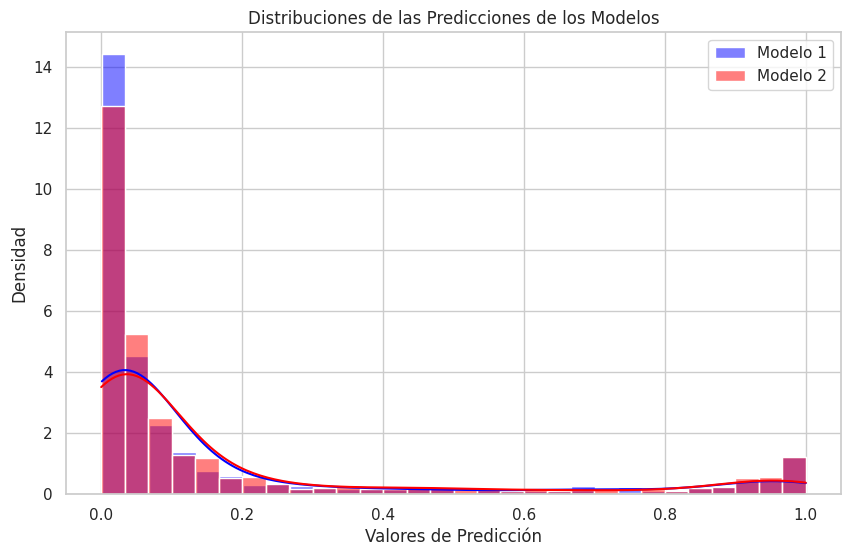

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de los gráficos
sns.set(style='whitegrid')

# Crear una figura y ejes para el gráfico
plt.figure(figsize=(10, 6))

# Graficar las distribuciones de las predicciones de ambos modelos
sns.histplot(predicciones_modelo_1, kde=True, color='blue', label='Modelo 1', stat="density", bins=30)
sns.histplot(predicciones_modelo_2, kde=True, color='red', label='Modelo 2', stat="density", bins=30)

# Agregar título y etiquetas
plt.title('Distribuciones de las Predicciones de los Modelos')
plt.xlabel('Valores de Predicción')
plt.ylabel('Densidad')
plt.legend()

# Mostrar el gráfico
plt.show()


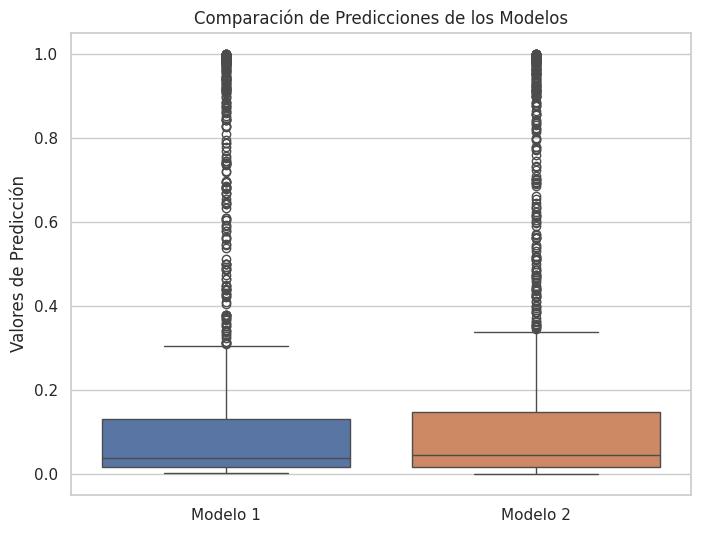

In [19]:
# Crear un dataframe para plotear con Seaborn
import pandas as pd

# Crear dataframe para las predicciones de ambos modelos
data = pd.DataFrame({
    'Modelo 1': predicciones_modelo_1,
    'Modelo 2': predicciones_modelo_2
})

# Graficar boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)

# Agregar título y etiquetas
plt.title('Comparación de Predicciones de los Modelos')
plt.ylabel('Valores de Predicción')

# Mostrar el gráfico
plt.show()


SPD&LOGNTXENT SVM VS SPDnet NTXENT 100%

In [30]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogNTXENTSVM/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetNTXENT/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9251057082452432
AUC-ROC del modelo 2: 0.9098562367864692
Estadística U: 818431.0
Valor p: 0.29129197745978286
No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.


SPD&LOGTriplet SVM vs SPDnet Triplet 100%


In [32]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogTripletSVM/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9266680761099364
AUC-ROC del modelo 2: 0.8942875264270613
Estadística U: 837991.0
Valor p: 0.978157081002456
No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.


SPD&LOGN SVM VS SPDnet 20% 2 perdidas

In [17]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogTripletSVM20%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet20%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.8735940803382665
AUC-ROC del modelo 2: 0.8120422832980974
Estadística U: 515511.0
Valor p: 1.273353759720384e-64
La diferencia en las predicciones es estadísticamente significativa.


SPD&LOGN SVM VS SPDnet 40% 2 perdidas

In [19]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogTripletSVM40%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet40%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9036575052854122
AUC-ROC del modelo 2: 0.8641522198731499
Estadística U: 723517.0
Valor p: 1.5109840791666406e-09
La diferencia en las predicciones es estadísticamente significativa.


SPD&LOGN SVM VS SPDnet 60% 2 perdidas

In [21]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogTripletSVM60%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet60%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9143424947145877
AUC-ROC del modelo 2: 0.8906088794926005
Estadística U: 686383.0
Valor p: 1.299482320214856e-15
La diferencia en las predicciones es estadísticamente significativa.


SPD&LOGN SVM VS SPDnet 80% 2 perdidas

In [23]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDyLogTripletSVM80%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet80%/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9175264270613108
AUC-ROC del modelo 2: 0.8705539112050741
Estadística U: 844714.0
Valor p: 0.7445201600401183
No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.


# BoxPlot de predicciones por ISUP

$SPD\&Log \ NTXent \ SVM$

/tmp/ipykernel_790493/1180638354.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


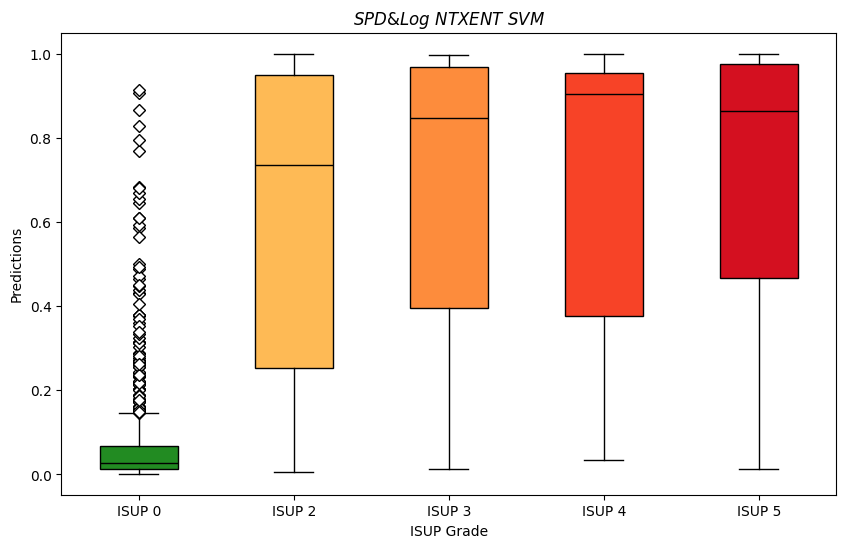

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
preds_SPDyLogNTXENT = np.load('/data/Predictions/SPDyLogNTXENTSVM/predictions_val.npy')
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(preds_SPDyLogNTXENT, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('ISUP Grade')
plt.ylabel('Predictions')
plt.title('$SPD&Log \ NTXENT \ SVM$')
plt.grid(False)

# plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotSPD&Log.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


$SPDnet \ NTXent$

/tmp/ipykernel_411705/3629627648.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


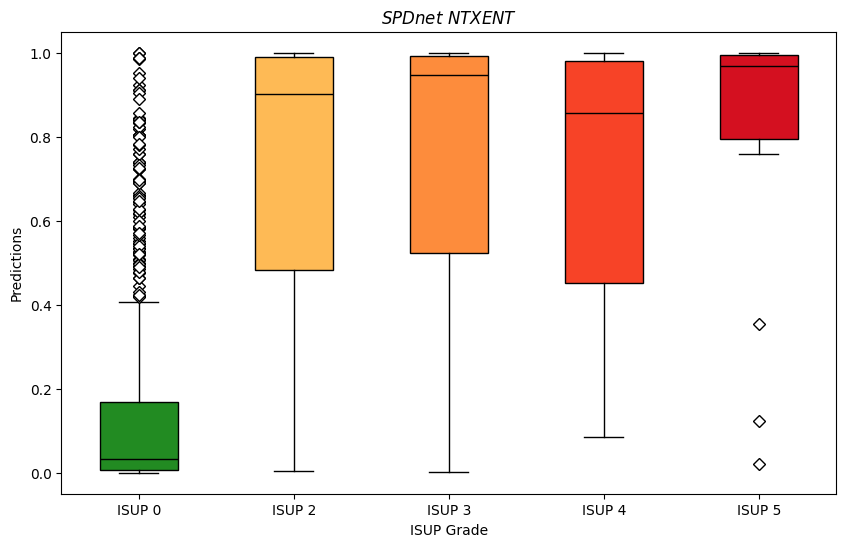

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
preds_SPDnetNTXENT = np.load('/data/Predictions/SPDnetNTXENT/predictions_val.npy')
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(preds_SPDnetNTXENT, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('ISUP Grade')
plt.ylabel('Predictions')
plt.title('$SPDnet \ NTXENT$')
plt.grid(False)

# plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotSPDnetNTXENT.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


$Baseline LR$

/tmp/ipykernel_472811/4197828895.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


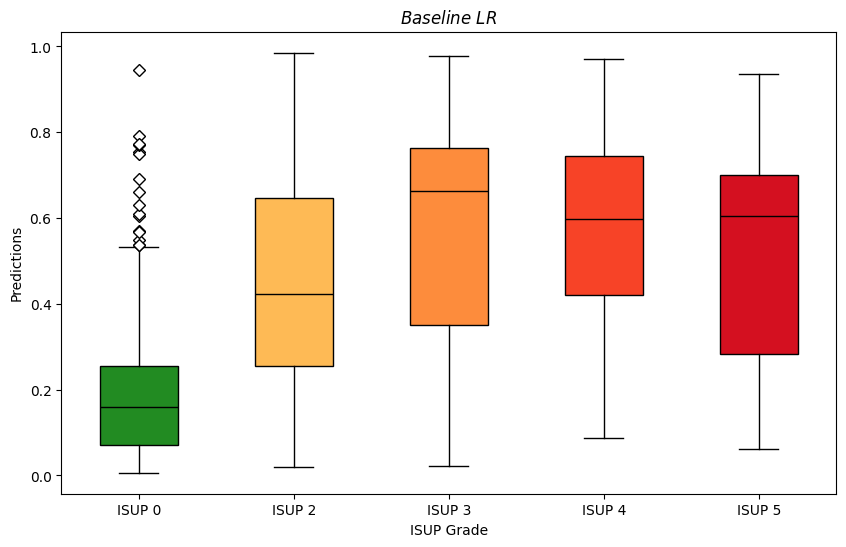

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the labelsISUP
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Initialize a list to store probabilities from all CSVs
lr_probs = []

# Load the 'lr_probs' column from each CSV file (i ranges from 1 to 5)
for i in range(1, 6):
    df = pd.read_csv(f'/data/Results/Experiments_Contrastive_CB3_17_Mayo/results/kfold_results_{i}.csv')
    lr_probs.extend(df['lr_probs'].values)

# Ensure lr_probs is a numpy array for easier processing
lr_probs = np.array(lr_probs)

# Check that the length of labelsISUP matches the total number of probabilities
assert len(labelsISUP) == len(lr_probs), "Mismatch in the number of labels and probabilities."

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize probabilities based on their corresponding ISUP grade
for prob, label in zip(lr_probs, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(prob)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('ISUP Grade')
plt.ylabel('Predictions')
plt.title('$Baseline \ LR$')
plt.grid(False)

# plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotBaselineLr.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


Mejor SPDnet NT-XENT vs Mejor SPDnet Triplet

In [2]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# Cargar las predicciones guardadas en archivos .npy
predicciones_modelo_1 = np.load('/data/Predictions/SPDnetNTXENT/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1
predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.9098562367864692
AUC-ROC del modelo 2: 0.8942875264270613
Estadística U: 840644.0
Valor p: 0.9108331034590103
No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.


Mejor Baseline NT-XENT vs Mejor Baseline Triplet

In [8]:
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

# # Cargar las predicciones guardadas en archivos .npy
# predicciones_modelo_1 = np.load('/data/Predictions/SPDnetNTXENT/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 1


# predicciones_modelo_2 = np.load('/data/Predictions/SPDnetTriplet/predictions_val.npy', allow_pickle=True)  # Predicciones del modelo 2

lr_probsntxent = []
lr_probstriplet = []

# Load the 'lr_probs' column from each CSV file (i ranges from 1 to 5)
for i in range(1, 6):
    dfntxent = pd.read_csv(f'/data/Results/Experiments_Contrastive_CB3_17_Mayo/results/kfold_results_{i}.csv')
    lr_probsntxent.extend(dfntxent['lr_probs'].values)
    
    dftriplet = pd.read_csv(f'/data/Results/Experiments_Contrastive_CB3_Triplet/results/kfold_results_{i}.csv')    
    lr_probstriplet.extend(dftriplet['lr_probs'].values)
    

lr_probsntxent = np.array(lr_probsntxent)
lr_probstriplet = np.array(lr_probstriplet)

predicciones_modelo_1 = lr_probsntxent
predicciones_modelo_2 = lr_probstriplet

# Cargar las etiquetas verdaderas
etiquetas_verdaderas = np.load('/data/ProstateContrastiveSPD/labels/labelsbinarios/labels_val.npy')  # Etiquetas verdaderas del conjunto de validación

# Calcular AUC-ROC para cada modelo
auc_model_1 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_1)
auc_model_2 = roc_auc_score(etiquetas_verdaderas, predicciones_modelo_2)

print(f"AUC-ROC del modelo 1: {auc_model_1}")
print(f"AUC-ROC del modelo 2: {auc_model_2}")

# Aplicar Mann-Whitney U test sobre las predicciones
statistic, p_value = stats.mannwhitneyu(predicciones_modelo_1, predicciones_modelo_2)

# Mostrar los resultados del test
print(f"Estadística U: {statistic}")
print(f"Valor p: {p_value}")

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("La diferencia en las predicciones es estadísticamente significativa.")
else:
    print("No hay suficiente evidencia para decir que la diferencia en las predicciones es significativa.")


AUC-ROC del modelo 1: 0.8418858350951375
AUC-ROC del modelo 2: 0.7112389006342497
Estadística U: 923709.0
Valor p: 7.562891196686161e-06
La diferencia en las predicciones es estadísticamente significativa.


# ============================================== PROMEDIO

/tmp/ipykernel_691392/3274203138.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


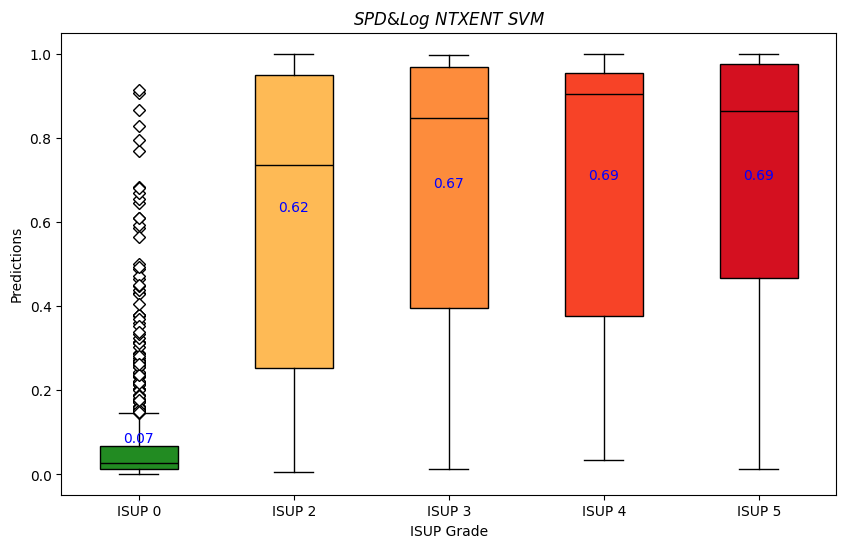

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
preds_SPDyLogNTXENT = np.load('/data/Predictions/SPDyLogNTXENTSVM/predictions_val.npy')
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(preds_SPDyLogNTXENT, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Anotación de los promedios (media) para cada boxplot
for i, preds in enumerate([predictions_by_isup[j] for j in [0, 2, 3, 4, 5]]):
    mean_value = np.mean(preds)  # Calcular el promedio
    plt.text(i + 1, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', color='blue', fontsize=10)

# Etiquetas y título
plt.xlabel('ISUP Grade')
plt.ylabel('Predictions')
plt.title('$SPD&Log \ NTXENT \ SVM$')
plt.grid(False)

# Guardar la figura si lo deseas
# plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotSPD&LogNTXENT_with_means.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()


/tmp/ipykernel_691392/2814912264.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


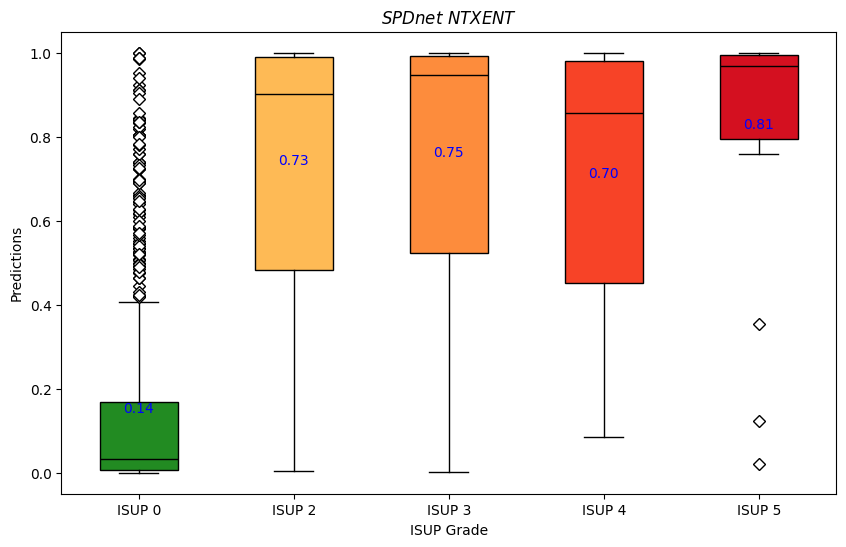

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
preds_SPDnetNTXENT = np.load('/data/Predictions/SPDnetNTXENT/predictions_val.npy')
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(preds_SPDnetNTXENT, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Anotación de los promedios (media) para cada boxplot
for i, preds in enumerate([predictions_by_isup[j] for j in [0, 2, 3, 4, 5]]):
    mean_value = np.mean(preds)  # Calcular el promedio
    plt.text(i + 1, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', color='blue', fontsize=10)

# Etiquetas y título
plt.xlabel('ISUP Grade')
plt.ylabel('Predictions')
plt.title('$SPDnet \ NTXENT$')
plt.grid(False)

# Guardar la figura si lo deseas
# plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotSPDnetNTXENT_with_means.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()


/tmp/ipykernel_691392/2459597143.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


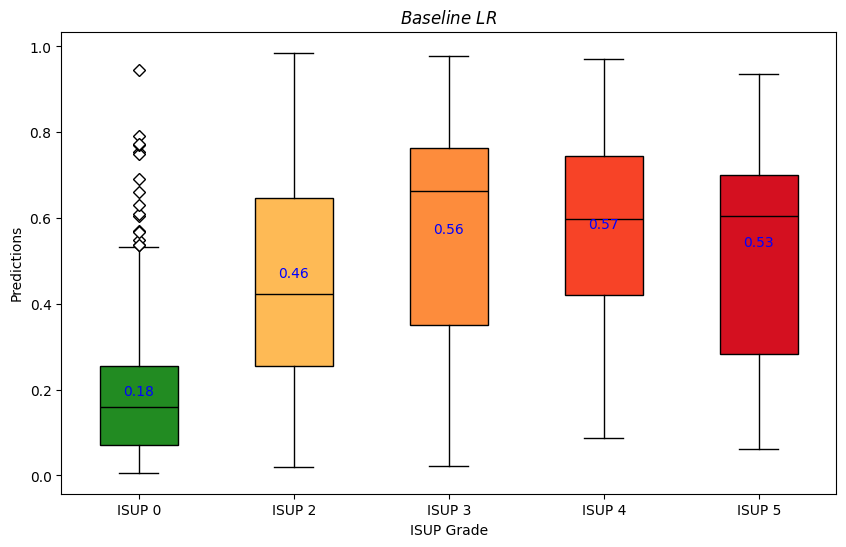

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the labelsISUP
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Initialize a list to store probabilities from all CSVs
lr_probs = []

# Load the 'lr_probs' column from each CSV file (i ranges from 1 to 5)
for i in range(1, 6):
    df = pd.read_csv(f'/data/Results/Experiments_Contrastive_CB3_17_Mayo/results/kfold_results_{i}.csv')
    lr_probs.extend(df['lr_probs'].values)

# Ensure lr_probs is a numpy array for easier processing
lr_probs = np.array(lr_probs)

# Check that the length of labelsISUP matches the total number of probabilities
assert len(labelsISUP) == len(lr_probs), "Mismatch in the number of labels and probabilities."

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize probabilities based on their corresponding ISUP grade
for prob, label in zip(lr_probs, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(prob)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Anotación de los promedios (media) para cada boxplot
for i, preds in enumerate([predictions_by_isup[j] for j in [0, 2, 3, 4, 5]]):
    mean_value = np.mean(preds)  # Calcular el promedio
    plt.text(i + 1, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', color='blue', fontsize=10)

# Etiquetas y título
plt.xlabel('ISUP Grade')
plt.ylabel('Predictions')
plt.title('$Baseline \ LR$')
plt.grid(False)

# Guardar la figura si lo deseas
# plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotBaselineLr_with_means.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Mostrar el gráfico
plt.show()


# ============================================== DISPERISIÓN

/tmp/ipykernel_965285/203825264.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


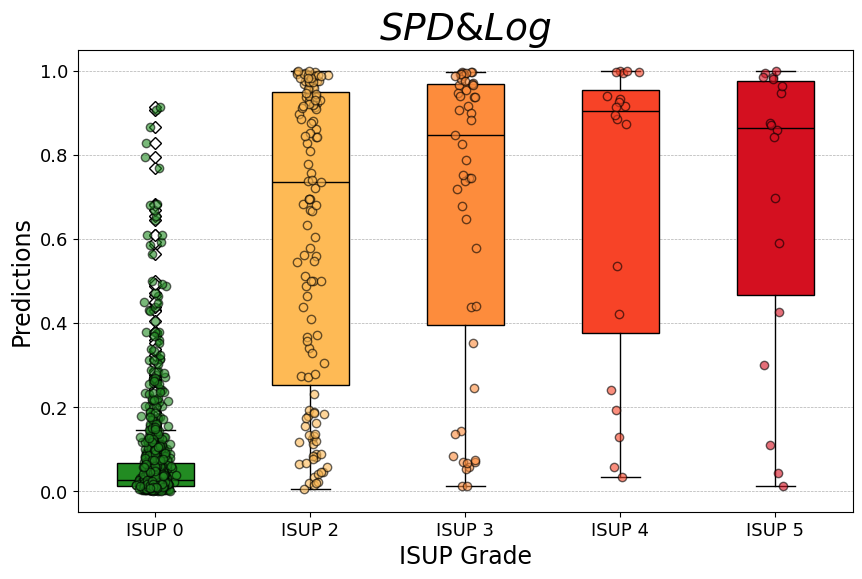

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
preds_SPDyLogNTXENT = np.load('/data/Predictions/SPDyLogNTXENTSVM/predictions_val.npy')
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(preds_SPDyLogNTXENT, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Adding scatter points with jitter above the boxplot
for i, grade in enumerate([0, 2, 3, 4, 5]):
    y = predictions_by_isup[grade]
    x = np.random.normal(i + 1, 0.04, size=len(y))  # Jitter alrededor de cada categoría
    plt.scatter(x, y, alpha=0.6, color=colors[i], edgecolor='black', zorder=3)  # zorder para que estén arriba

# Labels and title
plt.xlabel('ISUP Grade', fontsize=17)
plt.ylabel('Predictions', fontsize=17)
plt.title('$SPD&Log$', fontsize=27)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Cambiar el tamaño de los números del eje x e y usando plt
plt.xticks(fontsize=13)  # Tamaño de los números en el eje x
plt.yticks(fontsize=13)  # Tamaño de los números en el eje y

# Optional: Save the figure
plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotSPD&Log.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


/tmp/ipykernel_965285/1017705671.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


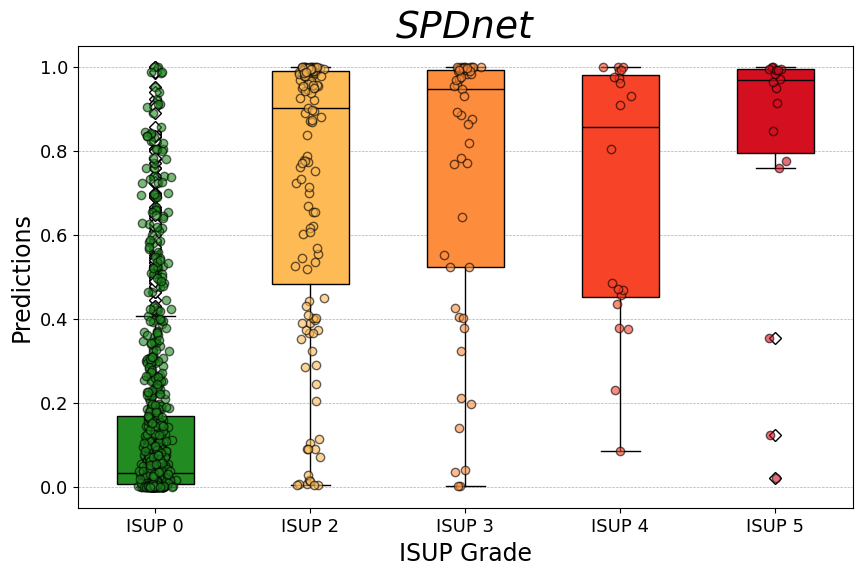

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
preds_SPDnetNTXENT = np.load('/data/Predictions/SPDnetNTXENT/predictions_val.npy')
labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(preds_SPDnetNTXENT, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Adding scatter points with jitter above the boxplot
for i, grade in enumerate([0, 2, 3, 4, 5]):
    y = predictions_by_isup[grade]
    x = np.random.normal(i + 1, 0.04, size=len(y))  # Jitter alrededor de cada categoría
    plt.scatter(x, y, alpha=0.6, color=colors[i], edgecolor='black', zorder=3)  # zorder para que estén arriba

# Labels and title
plt.xlabel('ISUP Grade', fontsize=17)
plt.ylabel('Predictions', fontsize=17)
plt.title('$SPDnet$', fontsize=27)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Cambiar el tamaño de los números del eje x e y usando plt
plt.xticks(fontsize=13)  # Tamaño de los números en el eje x
plt.yticks(fontsize=13)  # Tamaño de los números en el eje y



# Optional: Save the figure
plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotSPDnet.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


/tmp/ipykernel_965285/1438772071.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(


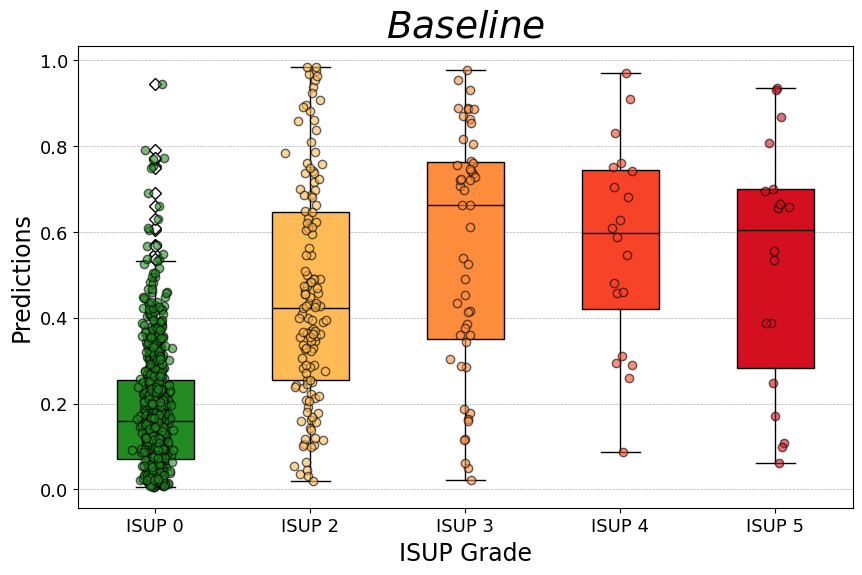

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions and labels
# Initialize a list to store probabilities from all CSVs
lr_probs = []

# Load the 'lr_probs' column from each CSV file (i ranges from 1 to 5)
for i in range(1, 6):
    df = pd.read_csv(f'/data/Results/Experiments_Contrastive_CB3_17_Mayo/results/kfold_results_{i}.csv')
    lr_probs.extend(df['lr_probs'].values)

# Ensure lr_probs is a numpy array for easier processing
lr_probs = np.array(lr_probs)


labelsISUP = np.load('/data/ProstateContrastiveSPD/labels/labelsISUP/labels_val.npy')

# Create a list to store predictions for each ISUP grade (0 to 5), omitting ISUP grade 1
predictions_by_isup = {i: [] for i in [0, 2, 3, 4, 5]}

# Organize predictions based on their corresponding ISUP grade
for pred, label in zip(lr_probs, labelsISUP):
    label_int = int(label)
    if label_int in predictions_by_isup:  # Omit ISUP grade 1
        predictions_by_isup[label_int].append(pred)

# Create boxplot, omitting ISUP grade 1
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    [predictions_by_isup[i] for i in [0, 2, 3, 4, 5]], 
    labels=[f'ISUP {i}' for i in [0, 2, 3, 4, 5]], 
    patch_artist=True,  # Necesario para cambiar el relleno
    boxprops=dict(color='black'),  # Borde de la caja
    medianprops=dict(color='black'),  # Color de la mediana
    whiskerprops=dict(color='black'),  # Color de los bigotes
    capprops=dict(color='black'),  # Color de las líneas finales de los bigotes
    flierprops=dict(markerfacecolor='white', marker='D')  # Color y estilo de los outliers
)

# Colores individuales para cada caja
colors = ['forestgreen', '#feba55ff', '#fd8c3cff', '#f74327ff', '#d41020ff']

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Adding scatter points with jitter above the boxplot
for i, grade in enumerate([0, 2, 3, 4, 5]):
    y = predictions_by_isup[grade]
    x = np.random.normal(i + 1, 0.04, size=len(y))  # Jitter alrededor de cada categoría
    plt.scatter(x, y, alpha=0.6, color=colors[i], edgecolor='black', zorder=3)  # zorder para que estén arriba

# Labels and title
plt.xlabel('ISUP Grade', fontsize=17)
plt.ylabel('Predictions', fontsize=17)
plt.title('$Baseline$', fontsize=27)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Cambiar el tamaño de los números del eje x e y usando plt
plt.xticks(fontsize=13)  # Tamaño de los números en el eje x
plt.yticks(fontsize=13)  # Tamaño de los números en el eje y



# Optional: Save the figure
plt.savefig('/data/ProstateContrastiveSPD/figslibro/boxplotBaseline.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


# Porcentajes para AUC-PR

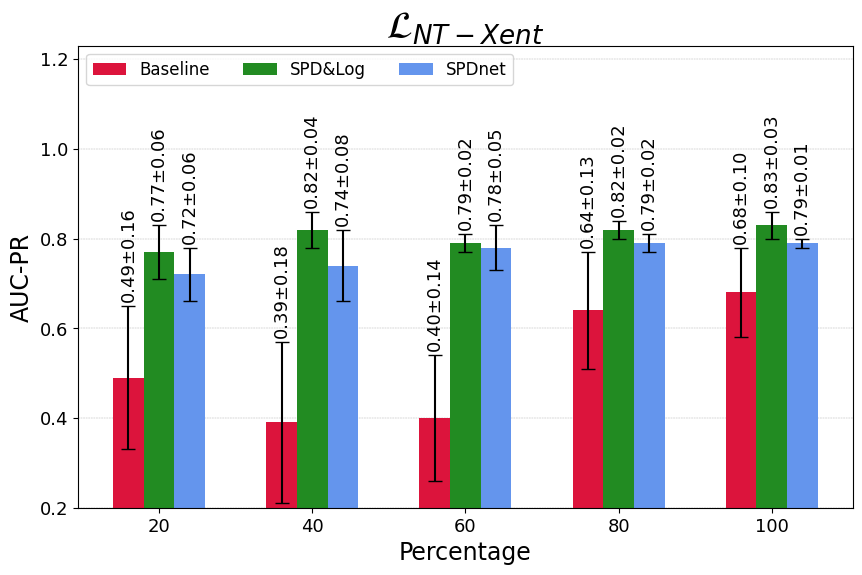

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset percentage and AUC values
dataset_percentage = [20, 40, 60, 80, 100]

# AUC values with standard deviations for each model
auc_baseline = [0.49, 0.39, 0.40, 0.64, 0.68]  # LR
auc_baseline_std = [0.16, 0.18, 0.14, 0.13, 0.10]  # Baseline std

auc_spd = [0.77, 0.82, 0.79, 0.82, 0.83]  # SVM
auc_spd_std = [0.06, 0.04, 0.02, 0.02, 0.03]  # SPD std

auc_spdnet = [0.72, 0.74, 0.78, 0.79, 0.79]
auc_spdnet_std = [0.06, 0.08, 0.05, 0.02, 0.01]  # 

# Width of the bars
bar_width = 0.2

# X-axis positions for each model
r1 = np.arange(len(dataset_percentage))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure grid lines are behind the bars
ax.set_axisbelow(True)

# Add horizontal grid lines only (soft)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.35)

# Plot the bars
ax.bar(r1, auc_baseline, width=bar_width, color='crimson', yerr=auc_baseline_std, capsize=5, label='Baseline')
ax.bar(r2, auc_spd, width=bar_width, color='forestgreen', yerr=auc_spd_std, capsize=5, label='SPD&Log')
ax.bar(r3, auc_spdnet, width=bar_width, color='cornflowerblue', yerr=auc_spdnet_std, capsize=5, label='SPDnet')

# Add text annotations for the AUC values on top of the bars with vertical rotation
for i in range(len(r1)):
    ax.text(r1[i], auc_baseline[i] + auc_baseline_std[i] + 0.009, f'{auc_baseline[i]:.2f}±{auc_baseline_std[i]:.2f}', 
             ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r2[i], auc_spd[i] + auc_spd_std[i] + 0.009, f'{auc_spd[i]:.2f}±{auc_spd_std[i]:.2f}', 
             ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r3[i], auc_spdnet[i] + auc_spdnet_std[i] + 0.009, f'{auc_spdnet[i]:.2f}±{auc_spdnet_std[i]:.2f}', 
             ha='center', va='bottom', fontsize=13, rotation=90)

# General layout
ax.set_title('$\mathcal{L}_{NT-Xent}$', fontsize=27)
ax.set_xlabel('Percentage', fontsize=17)
ax.set_ylabel('AUC-PR', fontsize=17)
ax.set_xticks([r + bar_width for r in range(len(dataset_percentage))])
ax.set_xticklabels(dataset_percentage)

# Cambiar el tamaño de los números del eje x e y
ax.tick_params(axis='x', labelsize=13)  # Tamaño de los números en el eje x
ax.tick_params(axis='y', labelsize=13)  # Tamaño de los números en el eje y
ax.set_ylim([0.2, 1.23])

# Add the legend in the upper left corner
ax.legend(loc='upper left', bbox_to_anchor=(0,1), frameon=True, ncol=3, fontsize=12)
plt.savefig('/data/ProstateContrastiveSPD/figslibro/auc_prNTXENT.pdf', format='pdf', bbox_inches='tight', dpi=300)


# Show the plot
plt.show()


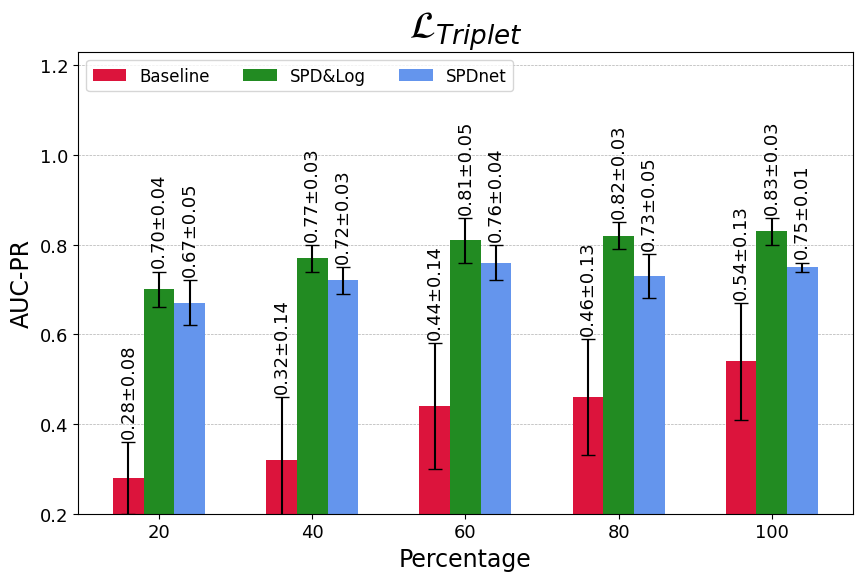

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset percentage and AUC values
dataset_percentage = [20, 40, 60, 80, 100]

# AUC values with standard deviations for each model
auc_baseline = [0.28, 0.32, 0.44, 0.46, 0.54]  # LR
auc_baseline_std = [0.08, 0.14, 0.14, 0.13, 0.13]  # Baseline std

auc_spd = [0.70, 0.77, 0.81, 0.82, 0.83]  # SVM
auc_spd_std = [0.04, 0.03, 0.05, 0.03, 0.03]  # SPD std

auc_spdnet = [0.67, 0.72, 0.76, 0.73, 0.75]
auc_spdnet_std = [0.05, 0.03, 0.04, 0.05, 0.01]  # 

# Width of the bars
bar_width = 0.2

# X-axis positions for each model
r1 = np.arange(len(dataset_percentage))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure grid lines are behind the bars
ax.set_axisbelow(True)

# Add horizontal grid lines only (soft)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Plot the bars
ax.bar(r1, auc_baseline, width=bar_width, color='crimson', yerr=auc_baseline_std, capsize=5, label='Baseline')
ax.bar(r2, auc_spd, width=bar_width, color='forestgreen', yerr=auc_spd_std, capsize=5, label='SPD&Log')
ax.bar(r3, auc_spdnet, width=bar_width, color='cornflowerblue', yerr=auc_spdnet_std, capsize=5, label='SPDnet')

# Add text annotations for the AUC values on top of the bars with vertical rotation
for i in range(len(r1)):
    ax.text(r1[i], auc_baseline[i] + auc_baseline_std[i] + 0.009, f'{auc_baseline[i]:.2f}±{auc_baseline_std[i]:.2f}', 
            ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r2[i], auc_spd[i] + auc_spd_std[i] + 0.009, f'{auc_spd[i]:.2f}±{auc_spd_std[i]:.2f}', 
            ha='center', va='bottom', fontsize=13, rotation=90)
    ax.text(r3[i], auc_spdnet[i] + auc_spdnet_std[i] + 0.009, f'{auc_spdnet[i]:.2f}±{auc_spdnet_std[i]:.2f}', 
            ha='center', va='bottom', fontsize=13, rotation=90)

# General layout
ax.set_title('$\mathcal{L}_{Triplet}$', fontsize=27)
ax.set_xlabel('Percentage', fontsize=17)
ax.set_ylabel('AUC-PR', fontsize=17)
ax.set_xticks([r + bar_width for r in range(len(dataset_percentage))])
ax.set_xticklabels(dataset_percentage)


# Cambiar el tamaño de los números del eje x e y
ax.tick_params(axis='x', labelsize=13)  # Tamaño de los números en el eje x
ax.tick_params(axis='y', labelsize=13)  # Tamaño de los números en el eje y
ax.set_ylim([0.2, 1.23])

# Add the legend in the upper left corner
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, ncol=3, fontsize=12)

plt.savefig('/data/ProstateContrastiveSPD/figslibro/auc_prTRIPLET.pdf', format='pdf', bbox_inches='tight', dpi=300)


# Show the plot
plt.show()
